In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path as osp
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import torch
from tqdm import tqdm
import json
import numpy as np
from typing import List


/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
from nb_utils.eval_utils import TEST, VALID, TRAIN, TEST_EXCLUDING_DIS, TEST_RESTRICTED_DIS
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import obtain_filtered_triples, split_test_triples_conditioned_on_ent_property, split_train_ents_by_existance_of_properties
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import make_results_dict_all_rel, make_results_dict_rel_breakdown

Change this cell to generate a report for other datasets/models:

In [4]:
SHARED_DATA_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp")
PROJ_DATA_DIR = Path("../data/")

In [5]:
# model registry
ROTATE = "rotate"
BIOBLP_D = "bioblp_d"

MODEL_ID_rotate = 'rotate-otxtubeb' 
MODEL_ID_bioblpd = 'bioblpd-38uz9fjs'

MODELS = {
    ROTATE: MODEL_ID_rotate,
    BIOBLP_D: MODEL_ID_bioblpd
}

In [6]:
model_registry_basedir = SHARED_DATA_DIR.joinpath(f"models")
model_registry_paths = {v: model_registry_basedir.joinpath(f"{v}") for v in MODELS.values()}
model_registry_paths

{'rotate-otxtubeb': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb'),
 'bioblpd-38uz9fjs': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/bioblpd-38uz9fjs')}

##  Loading model and data

make a keyword based switching statement b/w rotate and bioblp-d

In [41]:
def load_kge_model(model_base_path):
    model_path = model_base_path.joinpath("trained_model.pkl")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(model_path, map_location=torch.device(device))
    #train = TriplesFactory.from_path_binary(model_base_path.joinpath("training_triples"))
    return model
    

In [38]:
# load rotate, or bioblp-d
MODEL_ID = MODELS.get(ROTATE)    
model = load_kge_model(model_base_path = model_registry_paths[MODEL_ID])
train = TriplesFactory.from_path_binary(model_registry_paths[MODEL_ID].joinpath("training_triples"))

In [9]:
graph_path = PROJ_DATA_DIR.joinpath('biokgb/graph')
valid_triples = 'biokg.links-valid.csv'
test_triples = 'biokg.links-test.csv'
dummy_triples = 'biokg.links-dummy.csv'

creating a dummy set of triples for unit testing purposes

In [10]:
DUMMY = 'dummy'
dummy_triples = 'biokg.links-dummy.csv'
dummy_df = pd.read_csv(graph_path.joinpath(test_triples), sep="\t", header=None)[:50]
dummy_df.to_csv(graph_path.joinpath(dummy_triples), sep="\t", index=None, header=None)

In [11]:
valid, test, dummy = [TriplesFactory.from_path(graph_path.joinpath(f),
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (valid_triples, test_triples, dummy_triples)]

#### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

Create test sets: 
D; D_b, D_r; 

All biokgb entities surprisingly have a relation - > D_r is an empty set. -> This is because we used teh name of disease as decription in places where it was missing

In [13]:
#disease_descr_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg_meshid_to_descr_name-orig.tsv")
disease_descr_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg_meshid_to_descr_name.tsv")
disease_metadata_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg.metadata.disease.tsv")

# create a subset of biokg entities of type Disease 
diseases = pd.read_csv(disease_metadata_path, sep="\t", names=["disease", "rel", "node_type"])
disease_set = set(diseases.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal): {len(disease_set)}")

# create a set of disease entities for which we have text descriptions
disease_w_desc_df = pd.read_csv(disease_descr_path, sep="\t", header=0, names=["disease", "desc"])
disease_desc_set = set(disease_w_desc_df.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: {len(disease_desc_set)}")


# Disease entities in larger biokg (pre-benchmark removal): 11347
# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: 11347


In [14]:
# Side note: all disease entities in Biokgb have decscriptions; because missing values were plugged with disease names
disease_w_desc_df["len"] = disease_w_desc_df["desc"].str.len()
disease_w_desc_df.len.describe()

count    11347.000000
mean       149.042743
std        156.370558
min          5.000000
25%         37.000000
50%         70.000000
75%        231.000000
max       1076.000000
Name: len, dtype: float64

#### define test sets

In [17]:
test_triples_incl_dis_prop, test_triples_excl_dis_prop = split_test_triples_conditioned_on_ent_property(train, disease_set, disease_desc_set, test)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [17]:
# relations containing diseases include -> 
dis_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if 'DISEASE' in rel}
dis_assoc_rels

{'DISEASE_GENETIC_DISORDER': 3,
 'DISEASE_PATHWAY_ASSOCIATION': 4,
 'DRUG_DISEASE_ASSOCIATION': 7,
 'PROTEIN_DISEASE_ASSOCIATION': 14}

In [18]:
# equivalence of test_triples restricted on disease- assoc relationships and test_triples_incl_dis_prop above
#test_triples_disease = test.new_with_restriction(relations=list(dis_assoc_rels.values()))

In [19]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
#test_triples_disease = test.new_with_restriction(relations=list(dis_assoc_rels.values()))
#valid_triples_disease = valid.new_with_restriction(relations=list(dis_assoc_rels.values()))
print(f"# test triples with disease nodes: {test_triples_incl_dis_prop.num_triples}")
print(f"# valid triples with disease nodes: {test_triples_excl_dis_prop.num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with disease nodes: 17063
# valid triples with disease nodes: 168164


In [18]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,
    TEST_RESTRICTED_DIS: test_triples_incl_dis_prop,
    TEST_EXCLUDING_DIS: test_triples_excl_dis_prop,
    DUMMY: dummy, 
}

TEST_SET_LIST = [TEST_RESTRICTED_DIS, TEST_EXCLUDING_DIS, TEST, VALID]


### sanity check (only holds for diseases - can delete)

In [27]:
# redundant sanity check to ensure rels in the filtered test_triples_disease pertain to disease ent type
x = test_triples_incl_dis_prop.mapped_triples.view([-1, 3, 1])
ids = torch.ones(x.shape[0]).long()

{'DISEASE_GENETIC_DISORDER': 3, 'DISEASE_PATHWAY_ASSOCIATION': 4, 'DRUG_DISEASE_ASSOCIATION': 7, 'PROTEIN_DISEASE_ASSOCIATION': 14}


(array([ 261.,    0.,  293.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 6749.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 9760.]),
 array([ 3.        ,  3.36666667,  3.73333333,  4.1       ,  4.46666667,
         4.83333333,  5.2       ,  5.56666667,  5.93333333,  6.3       ,
         6.66666667,  7.03333333,  7.4       ,  7.76666667,  8.13333333,
         8.5       ,  8.86666667,  9.23333333,  9.6       ,  9.96666667,
        10.33333333, 10.7       , 11.06666667, 11.43333333, 11.8       ,
        12.16666667, 12.53333333, 12.9       , 13.26666667, 13.63333333,
        14.        ]),
 <BarContainer object of 30 artists>)

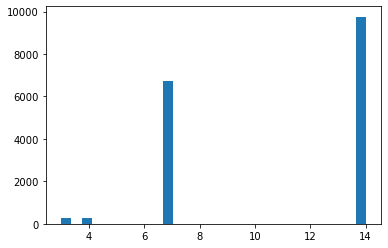

In [30]:
rels = np.array(x.gather(1, ids.view(-1, 1, 1)).squeeze())
np.unique(rels, return_counts=True)
print(dis_assoc_rels)
plt.hist(rels, bins = 30)

## Evaluation

In [20]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluator = RankBasedEvaluator(filtered=True)

wandb logging

In [21]:
import wandb
wandb.login()

WANDB_ENTITY_DISCOVERYLAB = "discoverylab"
WANDB_PROJECT_TRIAL = "bioblp-jupyter-trial"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmitra01 (discoverylab). Use `wandb login --relogin` to force relogin


In [22]:
def trial_func(x=1, y=2):
    print(x*y)
    return {'x': x, 'y':y}
 

In [26]:
# test run_experiment
#trial_func_kwargs = {"x": 1, "y": 2}
#metrics = run_experiment('dummy-run', TEST, BIOBLP_D, trial_func, **trial_func_kwargs) 

### Test on Valid dataset

create a function that evaluates and prints out scores for test, valid, valid_dis_restructed and test_dis_restricted triples

it should take a dictionary {test_set_name: test_set_triples}

In [35]:

def evaluate_lp_on_single_test_set(model, eval_test_set_slug, all_rels=True, split_by_rels=False):

    evaluator = RankBasedEvaluator()   
    # should we filtering more triples in the disease restricted test sets?
    filtered_triples = obtain_filtered_triples(test_type=eval_test_set_slug, 
                                               train_triples=triples_dict.get(TRAIN),
                                               valid_triples=triples_dict.get(VALID)
                                              )
    eval_result = evaluator.evaluate(model, triples_dict[eval_test_set_slug].mapped_triples,
                                     additional_filter_triples = filtered_triples)
    
    results_all_rels = make_results_dict_all_rel(eval_result, 
                                         relation='All', 
                                         relation_count=triples_dict.get(eval_test_set_slug).num_triples)
    
    # if split_by_rels: to add logic 
        
    return results_all_rels
        

In [33]:
from nb_utils.eval_utils import evaluate_lp_on_single_test_set

In [36]:
# dummy run
dummy_func_kwargs = {"model": model, "eval_test_set_slug": DUMMY}
dummy_results = evaluate_lp_on_single_test_set(**dummy_func_kwargs)
'''
results_microavg_test_retricted_dis = run_experiment_and_log_wandb(study_name='dummy-run-eval', 
                   test_set_slug=TEST_RESTRICTED_DIS, 
                   model_name=MODEL_ID, 
                   eval_func=evaluate_lp_on_single_test_set, 
                   **func_kwargs
                  )
'''


Evaluating on cuda:0: 100%|██████████| 50.0/50.0 [00:00<00:00, 63.0triple/s]


"\nresults_microavg_test_retricted_dis = run_experiment_and_log_wandb(study_name='dummy-run-eval', \n                   test_set_slug=TEST_RESTRICTED_DIS, \n                   model_name=MODEL_ID, \n                   eval_func=evaluate_lp_on_single_test_set, \n                   **func_kwargs\n                  )\n"

In [47]:
from typing import List, Union

def run_wandb_eval_all_rels_on_multiple_test_sets(model_id: str,
                                               test_set_list: List[str],
                                               eval_out_dir: Union[Path, str]):
    micro_results_dicts = {}
    STUDY_EVAL_MICRO_AVG = 'eval-micro-avg'
    eval_out_dir = Path(eval_out_dir)
    
    model = load_kge_model(model_registry_paths.get(MODEL_ID))
    
    for test_set_slug in TEST_SET_LIST:
        print(f"Model being evaluated: {MODEL_ID}, of type {type(model)}")
        func_kwargs = {"model": model, "eval_test_set_slug": test_set_slug}

        rel_results = run_experiment_and_log_wandb(study_name=STUDY_EVAL_MICRO_AVG, 
                       test_set_slug=test_set_slug, 
                       model_name=MODEL_ID, 
                       eval_func=evaluate_lp_on_single_test_set, 
                       **func_kwargs
                      )
        micro_results_dicts[test_set_slug] = rel_results

    with open(eval_out_dir.joinpath(f'{STUDY_EVAL_MICRO_AVG}.json'), 'w+') as f:
        json.dump(micro_results_dicts, f)

In [ ]:
# parameterise MODEL_NAME_SLUG as single point of entry into chain of model related parameters
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
DUMMY_TEST_LIST = [DUMMY]
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_all_rels_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=DUMMY_TEST_LIST,
                                             eval_out_dir=eval_out_dir)

Model being evaluated: rotate-otxtubeb, of type <class 'pykeen.models.unimodal.rotate.RotatE'>


In [ ]:
MODEL_NAME_SLUG = BIOBLPD
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
DUMMY_TEST_LIST = [DUMMY]
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_all_rels_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=TEST_SET_LIST,
                                             eval_out_dir=eval_out_dir)

In [25]:
model_name = MODEL_ID
for test_set_slug in TEST_SET_LIST:
    func_kwargs = {"model": model, "eval_test_set_slug": test_set_slug}

    run_experiment(study_name='eval-micro-avg', 
                   test_set_slug=test_set_slug, 
                   model_name=model_name, 
                   eval_func=evaluate_lp_on_single_test_set, 
                   **func_kwargs
                  )

Evaluating on cuda:0: 100%|██████████| 17.1k/17.1k [02:55<00:00, 97.0triple/s]


Evaluating on cuda:0: 100%|██████████| 168k/168k [29:10<00:00, 96.1triple/s] 


Evaluating on cuda:0: 100%|██████████| 185k/185k [32:09<00:00, 96.0triple/s] 


Evaluating on cuda:0: 100%|██████████| 185k/185k [31:44<00:00, 97.3triple/s] 


## Evaluating over specific. relation types

In [28]:
def eval_breakdown_by_rel_type(eval_test_set_slug, model):
    result_dicts =[]
    test_triples = triples_dict[eval_test_set_slug]
    additional_filter_triples = obtain_filtered_triples(test_type=eval_test_set_slug, 
                                                        train_triples=triples_dict[TRAIN],
                                                        valid_triples=triples_dict[VALID]
                                                       )
    for relation in tqdm(list(triples_dict[TRAIN].relation_to_id)[:], desc='Evaluating over each relation'):
        triples_subset = test_triples.new_with_restriction(relations=[relation])
        if triples_subset.num_triples > 0:
            subset_result = evaluator.evaluate(model,
                                               triples_subset.mapped_triples, 
                                               additional_filter_triples=additional_filter_triples,
                                               use_tqdm=False)
            result_dicts.append({'results': subset_result, 'relation': relation, 'count': triples_subset.num_triples})
    results_df = pd.DataFrame([make_results_dict_all_rel(d['results'], d['relation'], d['count']) for d in result_dicts])
    rel_results_dict = results_df.set_index('Relation').transpose().to_dict()
    return rel_results_dict

In [30]:
out_dir = Path(f'metrics/{MODEL_ID}')
out_dir.exists()

True

In [ ]:
model_name = MODEL_ID
STUDY_EVAL_REL_BREAKDOWN = 'eval-rel-breakdown'
out_dir = Path(f'metrics/{MODEL_ID}')
rel_results_dicts = {}
for test_set_slug in TEST_SET_LIST:
    func_kwargs = {"model": model,
                  "eval_test_set_slug": test_set_slug}

    rel_results = run_experiment(study_name=STUDY_EVAL_REL_BREAKDOWN, 
                   test_set_slug=test_set_slug, 
                   model_name=model_name, 
                   eval_func=eval_breakdown_by_rel_type, 
                   **func_kwargs
                  )
    rel_results_dicts[test_set_slug] = rel_results
    
with open(out_dir.joinpath(f'{STUDY_EVAL_REL_BREAKDOWN}.json'), 'w+') as f:
    json.dump(rel_results_dicts, f)


Evaluating over each relation: 100%|██████████| 17/17 [05:18<00:00, 18.76s/it]


                      Relation  Count  arithmetic_mean_rank  \
0     DISEASE_GENETIC_DISORDER    261            758.760559   
1  DISEASE_PATHWAY_ASSOCIATION    293            841.361755   
2     DRUG_DISEASE_ASSOCIATION   6749            417.342316   
3  PROTEIN_DISEASE_ASSOCIATION   9760           2088.663818   

   adjusted_arithmetic_mean_rank  inverse_harmonic_mean_rank  hits_at_1  \
0                       0.014313                    0.934612   0.927203   
1                       0.015869                    0.331824   0.261092   
2                       0.007879                    0.092318   0.043932   
3                       0.039461                    0.214140   0.157428   

   hits_at_3  hits_at_5  hits_at_10  
0   0.938697   0.944444    0.946360  
1   0.361775   0.402730    0.452218  
2   0.092236   0.123870    0.181731  
3   0.223361   0.264498    0.325973  


Evaluating over each relation: 100%|██████████| 17/17 [34:50<00:00, 122.98s/it] 

                       Relation   Count  arithmetic_mean_rank  \
0            COMPLEX_IN_PATHWAY     878            171.463547   
1     COMPLEX_TOP_LEVEL_PATHWAY    1649           2711.817383   
2                           DDI  120830             10.219083   
3                           DPI     527            791.814026   
4                  DRUG_CARRIER      13             51.884617   
5                   DRUG_ENZYME      67            105.402985   
6      DRUG_PATHWAY_ASSOCIATION     426            215.424881   
7                   DRUG_TARGET     745            236.403351   
8              DRUG_TRANSPORTER      35            914.185730   
9             MEMBER_OF_COMPLEX    8127            110.822472   
10                          PPI   10669           5289.458496   
11  PROTEIN_PATHWAY_ASSOCIATION   23949           2174.163818   
12     RELATED_GENETIC_DISORDER     249          19583.873047   

    adjusted_arithmetic_mean_rank  inverse_harmonic_mean_rank  hits_at_1  \
0            

Evaluating over each relation:  88%|████████▊ | 15/17 [35:08<03:31, 105.75s/it] 

In [ ]:
model_name = MODEL_ID
STUDY_EVAL_REL_BREAKDOWN = 'eval-rel-breakdown'
out_dir = Path(f'metrics/{MODEL_ID}')
rel_results_dicts = {}
for test_set_slug in TEST_SET_LIST:
    func_kwargs = {"model": model,
                  "eval_test_set_slug": test_set_slug}

    rel_results = run_experiment(study_name=STUDY_EVAL_REL_BREAKDOWN, 
                   test_set_slug=test_set_slug, 
                   model_name=model_name, 
                   eval_func=eval_breakdown_by_rel_type, 
                   **func_kwargs
                  )
    rel_results_dicts[test_set_slug] = rel_results
    
with open(out_dir.joinpath(f'{STUDY_EVAL_REL_BREAKDOWN}.json'), 'w+') as f:
    json.dump(rel_results_dicts, f)


Evaluating over each relation: 100%|██████████| 17/17 [05:34<00:00, 19.70s/it]


                      Relation  Count  arithmetic_mean_rank  \
0     DISEASE_GENETIC_DISORDER    261           2200.370605   
1  DISEASE_PATHWAY_ASSOCIATION    293           3717.679932   
2     DRUG_DISEASE_ASSOCIATION   6749           1575.149048   
3  PROTEIN_DISEASE_ASSOCIATION   9760           5188.562500   

   adjusted_arithmetic_mean_rank  inverse_harmonic_mean_rank  hits_at_1  \
0                       0.041507                    0.632742   0.590038   
1                       0.070119                    0.116742   0.078498   
2                       0.029739                    0.025802   0.009409   
3                       0.098028                    0.064648   0.047490   

   hits_at_3  hits_at_5  hits_at_10  
0   0.647510   0.683908    0.724138  
1   0.141638   0.162116    0.180887  
2   0.022300   0.031338    0.052008  
3   0.066393   0.078279    0.095236  


Evaluating over each relation: 100%|██████████| 17/17 [36:11<00:00, 127.76s/it] 

                       Relation   Count  arithmetic_mean_rank  \
0            COMPLEX_IN_PATHWAY     878           1644.980103   
1     COMPLEX_TOP_LEVEL_PATHWAY    1649           6719.250000   
2                           DDI  120830             24.388937   
3                           DPI     527           2276.004150   
4                  DRUG_CARRIER      13           2213.961426   
5                   DRUG_ENZYME      67            962.276123   
6      DRUG_PATHWAY_ASSOCIATION     426           1467.138550   
7                   DRUG_TARGET     745            825.566101   
8              DRUG_TRANSPORTER      35           2602.728516   
9             MEMBER_OF_COMPLEX    8127            714.172363   
10                          PPI   10669           8169.080566   
11  PROTEIN_PATHWAY_ASSOCIATION   23949           4110.860840   
12     RELATED_GENETIC_DISORDER     249          30198.205078   

    adjusted_arithmetic_mean_rank  inverse_harmonic_mean_rank  hits_at_1  \
0            

Evaluating over each relation:  12%|█▏        | 2/17 [01:43<13:07, 52.51s/it]

## analyse effect of node degree?
1. compute a degree table for entities in train

In [ ]:
training_df = pd.DataFrame(train.triples, columns=[COL_SOURCE, COL_EDGE, COL_TARGET])
training_df[:2]

In [ ]:
# not a nec step, but to ease computation, let's restrict the triples to disease node containg triples
training_df = training_df[training_df[COL_EDGE].isin(list(dis_assoc_rels.keys()))]
training_df.rel.value_counts()

In [ ]:
def compute_node_degrees(triple_df):
    out_degree_df = training_df.groupby(COL_SOURCE)[COL_EDGE].agg("count").reset_index()
    out_degree_df.rename(columns={COL_SOURCE: COL_NODE, COL_EDGE: OUT_DEGREE}, inplace=True)
    in_degree_df = training_df.groupby(COL_TARGET)[COL_EDGE].agg("count").reset_index()
    in_degree_df.rename(columns={COL_TARGET: COL_NODE, COL_EDGE: IN_DEGREE}, inplace=True)
    node_degree_df = out_degree_df.merge(in_degree_df, on=COL_NODE, how="outer")
    node_degree_df = node_degree_df.fillna(0)
    node_degree_df[DEGREE] = node_degree_df.in_degree+node_degree_df.out_degree
    node_degree_df = node_degree_df.fillna(0)
    return node_degree_df


In [ ]:
node_degree_df = compute_node_degrees(training_df)

In [ ]:
node_degree_df["is_disease"] = node_degree_df[COL_NODE].apply(lambda x: x in biokgb_disease_ents)
dis_node_degree_df = node_degree_df[node_degree_df.is_disease]
dis_node_degree_df[:2]

In [ ]:
# now bucket the test triples according to node degree
dis_degree_dict = pd.Series(dis_node_degree_df.degree.values,index=dis_node_degree_df.ent).to_dict()
test_triples_dis_df = pd.DataFrame(test_triples_disease.triples, columns=["src", "rel", "tgt"])
def retrieve_node_degree(node, node2degree_dict):
    return node2degree_dict.get(node, 0)

test_triples_dis_df["src_dis_degree"] = test_triples_dis_df["src"].apply(lambda x: retrieve_node_degree(x, dis_degree_dict))
test_triples_dis_df["tgt_dis_degree"] = test_triples_dis_df["tgt"].apply(lambda x: retrieve_node_degree(x, dis_degree_dict))
test_triples_dis_df["dis_degree"] = test_triples_dis_df.src_dis_degree + test_triples_dis_df.tgt_dis_degree
test_triples_dis_df[:3]  
test_triples_dis_df.head()

In [ ]:
test_triples_dis_df.dis_degree.describe()

### average performance predicting the node which has an entity degree of x

Let's focus only on 'PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION' which have more support.

The disease entity is the tail entity in these triples

In [ ]:
test_triples_dis_tail_df = test_triples_dis_df.loc[test_triples_dis_df[COL_EDGE].isin(['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION'])]
test_triples_dis_tail_df[:2]

In [ ]:
dis_degree_values = test_triples_dis_df["dis_degree"].unique()
dis_degree_values[0]

In [ ]:
import seaborn as sns
disease_degrees = test_triples_dis_tail_df.groupby(['dis_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=disease_degrees, x='dis_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

In [ ]:
from pykeen.triples.triples_factory import TriplesFactory
evaluator = RankBasedEvaluator()

def compute_metrics_over_triples_with_disease_tails(test_triples_w_node_degree_df, test_set_slug):#, quantiles=quantiles_map.keys()):
    if VALID in test_set_slug:
        test_type = VALID
    else:
        test_type = TEST
    additional_filter_triples = obtain_filtered_triples(test_type=test_type,
                                                        train_triples=triples_dict[TRAIN],
                                                        valid_triples=triples_dict[VALID]
                                                       )
    test_triples_with_dis_tail_df = test_triples_w_node_degree_df.loc[test_triples_w_node_degree_df[COL_EDGE].isin(['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION'])]
    dis_degree_values = test_triples_with_dis_tail_df["dis_degree"].unique()
    result_dicts = []
    
    for degree_val in tqdm(dis_degree_values): 
        df_subset = test_triples_with_dis_tail_df.loc[test_triples_with_dis_tail_df["dis_degree"]==degree_val][[COL_SOURCE, COL_EDGE, COL_TARGET]]
        triples_subset = df_subset.values
        triples_subset = TriplesFactory.from_labeled_triples(triples_subset, 
                                                             relation_to_id=triples_dict[TRAIN].relation_to_id, 
                                                             entity_to_id=triples_dict[TRAIN].entity_to_id)
        if triples_subset.num_triples > 0:
            subset_result = evaluator.evaluate(model,
                                               triples_subset.mapped_triples, 
                                               additional_filter_triples=additional_filter_triples,
                                               use_tqdm=False)
            result_dicts.append({'dis_degree': degree_val, 'results': subset_result, 'relation': 'All', 'count': triples_subset.num_triples})
    return result_dicts



In [ ]:
MODEL_ID = MODELS.get(ROTATE)
base_path = SHARED_DATA_DIR.joinpath(f"models/{MODEL_ID}")
model_path = base_path.joinpath("trained_model.pkl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load(model_path, map_location=torch.device(device))
#train = TriplesFactory.from_path_binary(base_path.joinpath("training_triples"))

In [ ]:
results_by_node_degree_bioblpd = compute_metrics_over_triples_with_disease_tails(test_triples_dis_df, test_set_slug=TEST_RESTRICTED_DIS)

In [ ]:
results_by_node_degree = compute_metrics_over_triples_with_disease_tails(test_triples_dis_df, test_set_slug=TEST_RESTRICTED_DIS)

In [ ]:
results_by_node_degree_dicts_bioblpd = {}
for result in results_by_node_degree:
         results_by_node_degree_dicts_bioblpd[result['dis_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )
results_by_node_degree_dicts_bioblpd

In [ ]:
metric_name = 'hits_at_1'
degrees = list(results_by_node_degree_dicts_bioblpd.keys())
metrics = []
for deg, metric in results_by_node_degree_dicts_bioblpd.items():
    metrics.append(metric[metric_name])
model_name

In [ ]:
sns.scatterplot(degreeBIOBLP_D metrics)
plt.xscale('log')
plt.ylabel(metric_name)
plt.title(f'Average {metric_name} predicting disease nodes Vs. disease node degree | Model: {model_name}')

In [ ]:
MODEL_ID = MODELS.get(ROTATE)
base_path = SHARED_DATA_DIR.joinpath(f"models/{MODEL_ID}")
model_path = base_path.joinpath("trained_model.pkl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load(model_path, map_location=torch.device(device))
#train = TriplesFactory.from_path_binary(base_path.joinpath("training_triples"))

In [ ]:
results_by_node_degree_rotate = compute_metrics_over_triples_with_disease_tails(test_triples_dis_df, test_set_slug=TEST_RESTRICTED_DIS)

In [ ]:
results_by_node_degree_dicts_rotate = {}
for result in results_by_node_degree_rotate:
         results_by_node_degree_dicts_rotate[result['dis_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )
results_by_node_degree_dicts_rotate

In [ ]:
with open(f'{MODEL_ID}-node-degree-eval.json', 'w+') as f:
    json.dump(results_by_node_degree_dicts_rotate, f)


In [ ]:
metric_name = 'hits_at_10'
degrees = list(results_by_node_degree_dicts_rotate.keys())
metrics = []
for deg, metric in results_by_node_degree_dicts_rotate.items():
    metrics.append(metric[metric_name])
MODEL_ID

In [ ]:
sns.scatterplot(degrees, metrics)
plt.xscale('log')
plt.ylabel(metric_name)
plt.title(f'Average {metric_name} predicting disease nodes Vs. disease node degree | Model: {MODEL_ID}')

In [ ]:
sns.scatterplot(degreeBIOBLP_D metrics)
plt.xscale('log')
plt.ylabel(metric_name)
plt.title(f'Average {metric_name} predicting disease nodes Vs. disease node degree | Model: {model_name}')

In [ ]:
#import PIL
#degree_analysis_hits_at_10_rotate_path = 
#degree_analysis_hits_at_1_rotate_path = 
degree_analysis_hits_at_10_bioblpd_path = Path("./data/imgs/node_analysis_hits_at_10_bioblpd.png")
degree_analysis_hits_at_1_bioblpd_path = Path("./data/imgs/node_analysis_hits_at_1_bioblpd.png")

wandb.log({"example": wandb.Image(degree_analysis_hits_at_10_bioblpd_path)})

## 

## archived

### previous stuff

How do MRR, H@k, and AMR correlate?

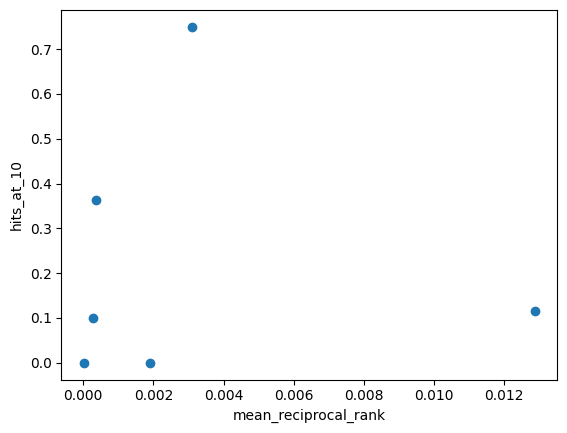

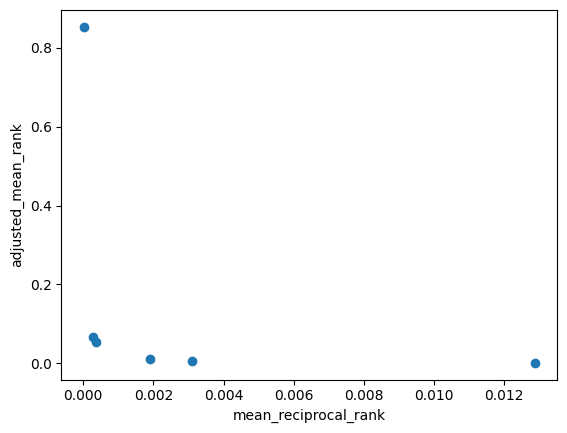

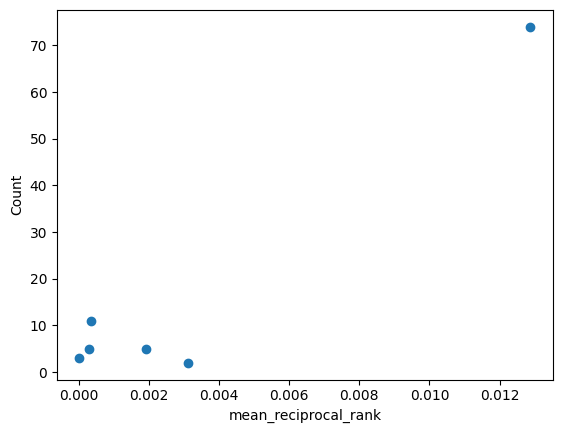

In [32]:
def plot_metric_pair(results_df, metric_1: str, metric_2: str):
    """Make a scatter plot with one link prediction metric in each axis."""
    plt.figure()
    plt.scatter(results_df[metric_1], results_df[metric_2])
    plt.xlabel(metric_1)
    plt.ylabel(metric_2)

plot_metric_pair(results_df, 'mean_reciprocal_rank', 'hits_at_10')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'adjusted_mean_rank')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'Count')

What are the relations where the model performs better?

In [33]:
def per_relation_plot(results_df, metric: str):
    """Make a bar plot of link prediction performance for each relation."""
    results_df[['Relation', metric]].sort_values(by=metric).plot.barh(x='Relation', figsize=(5, 5), grid=True)

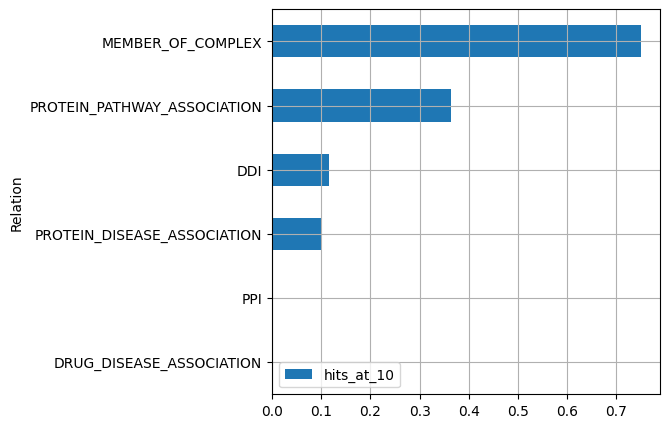

In [34]:
per_relation_plot(results_df, 'hits_at_10')

### Evaluating over specific entity and relation types
The source csv files contain the triples, plus extra information like the types of the entities involved in the triple. We will extract the type information.

We can see that restricting predictions over the correct domain and range of a relation only slightly increases the results.

In [ ]:
can you do an. analysis on degree....
compare rotate to this